In [1]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

In [2]:
from src.loadProcessed import load_location_effects

data = load_location_effects()

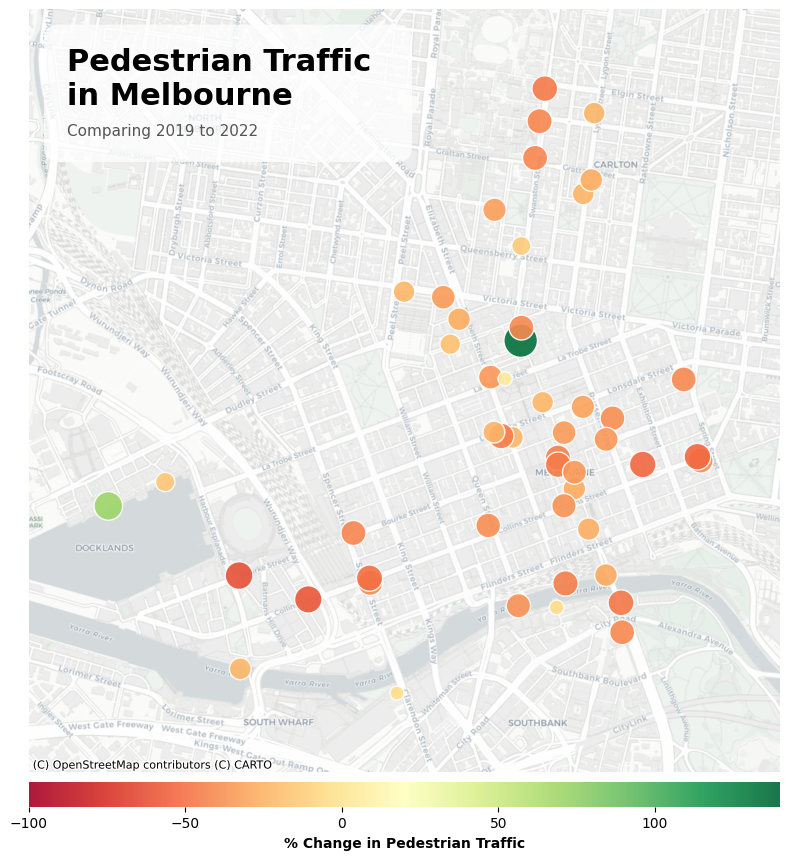

In [ ]:
from pyproj import Transformer
import matplotlib.patches as patches

plot_data = data.copy()
plot_data['magnitude'] = plot_data['percentage_change'].abs()

# Convert lat/lon to Web Mercator (meters) for Contextily
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_data['x'], plot_data['y'] = transformer.transform(plot_data['longitude'].values, plot_data['latitude'].values)

fig, ax = plt.subplots(figsize=(8, 10))

# Scatter points
sc = ax.scatter(
    plot_data['x'], plot_data['y'],
    cmap='RdYlGn', 
    c=plot_data['percentage_change'],
    vmin=-100, vmax=140,
    edgecolors='white',
    s= 50 * np.sqrt(plot_data['magnitude']),
    alpha=.9,
    zorder=2
)

# Add colourbar
cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', 
                    fraction=0.03, pad=0.01, aspect=30)
cbar.set_label('% Change in Pedestrian Traffic', fontsize=10, weight='bold')
cbar.outline.set_visible(False)

# Set limits with a small buffer
buffer = 500
ax.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
ax.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

ax.set_aspect('equal')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

# Add Title Box

ax.text(0.05, 0.95, "Pedestrian Traffic\nin Melbourne", 
        transform=ax.transAxes, 
        fontsize=22, fontweight='bold', 
        va='top', ha='left',
        linespacing=1.2,
        zorder=11)

ax.text(0.05, 0.85, "Comparing 2019 to 2022", 
        transform=ax.transAxes, 
        fontsize=11, color='#555555',
        va='top', ha='left',
        zorder=11)

ax.add_artist(patches.FancyBboxPatch(
    (0.04, 0.82), 0.45, 0.14, # (x, y), width, height in axes fraction
    transform=ax.transAxes,
    boxstyle="round,pad=0.02",
    facecolor='white', 
    edgecolor='none', 
    alpha=0.75, 
    zorder=10
))

plt.tight_layout()
plt.show()


In [4]:
import pydeck as pdk

increases = data[data['total_year_effect'] > 1.0]

decreases = data.loc[data['total_year_effect'] <= 1.0].copy()
decreases['absolute_change'] = abs(decreases['percentage_change'])

# View over Melbourne CBD
view_state = pdk.ViewState(
    longitude=144.96,
    latitude=-37.813,
    zoom=14.7,
    pitch=55,
    bearing=-60,
)

view = pdk.View(
    controller=False
)

# ColumnLayer for extrusion
increase_layer = pdk.Layer(
    "ColumnLayer",
    data=increases[['longitude', 'latitude', 'percentage_change', 'sensor_description']],  # only the columns we need
    get_position=["longitude", "latitude"],
    get_elevation="percentage_change",
    elevation_scale=5,   # increase for visibility
    radius=20,
    get_fill_color=[100, 255, 100],
    extruded=True,
    pickable=True,
)

decrease_layer = pdk.Layer(
    "ColumnLayer",
    data=decreases[['longitude', 'latitude', 'percentage_change', 'absolute_change', 'sensor_description']],  # only the columns we need
    get_position=["longitude", "latitude"],
    get_elevation="absolute_change",
    elevation_scale=5,   # increase for visibility
    radius=20,
    get_fill_color=[255, 100, 100],
    extruded=True,
    pickable=True,
)

osm_tiles = pdk.Layer(
    "TileLayer",
    data=["https://tile.openstreetmap.org/{z}/{x}/{y}.png"],
    min_zoom=0,
    max_zoom=19,
    tile_size=256,
    pickable=False,
    opacity=1,
)

r = pdk.Deck(
    layers=[osm_tiles, increase_layer, decrease_layer],
    initial_view_state=view_state,
    tooltip={
        "text": "{sensor_description} \nChange: {percentage_change}%"
    },
)

r.to_html("melbourne_cbd_3d.html")


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 13
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   sensor_effect       50 non-null     float64       
 1   year_effect         50 non-null     float64       
 2   sensor_id           50 non-null     category      
 3   sensor_description  50 non-null     object        
 4   sensor_name         50 non-null     object        
 5   installation_date   50 non-null     datetime64[ns]
 6   note                25 non-null     object        
 7   status              50 non-null     object        
 8   latitude            50 non-null     float64       
 9   longitude           50 non-null     float64       
 10  location            50 non-null     object        
 11  total_year_effect   50 non-null     float64       
 12  percentage_change   50 non-null     float64       
dtypes: category(1), datetime64[ns](1), float64(6), object(5)
